# Detection of Anomalies in Financial Transactions using Adversarial Autoencoder Neural Networks

## Submitted By: Dilip Singh,
### Student Id 3137898

## Introduction
Detecting anomalies and novel events is vital to the financial industry. These events are often indicative of illegal activities such as credit card fraud, identity theft, network intrusion and money laundering. Left unchecked, these activities can cause poor customer experiences and billions of dollars in losses. In addition to these activities, a new threat is emerging in the form of fake news in financial media outlets that can lead to distortions in trading strategies and investment decisions. A number of new techniques are emerging to tackle these problems including semi-supervised learning methods, deep learning algorithms, network/graph based solutions as well as linguistic approaches. These methods must often be able to work in real-time and be able to handle large volumes of data. 

This project will analyse the effictiveness of Adversial Autoencoder Neural(AAE) Networks model for detection of analalies in financial transacations. I will demonstrate that such artificial neural networks are capable of learning a semantic meaningful representation of real-world journal entries. The learned
representation provides a holistic view on a given set of journal
entries and significantly improves the interpretability of detected
accounting anomalies. 

It will show that such a representation combined with the networks reconstruction error can be utilized as
an unsupervised and highly adaptive anomaly assessment and will be useul to identified the fraud financial transaction or  for forensic audit. 

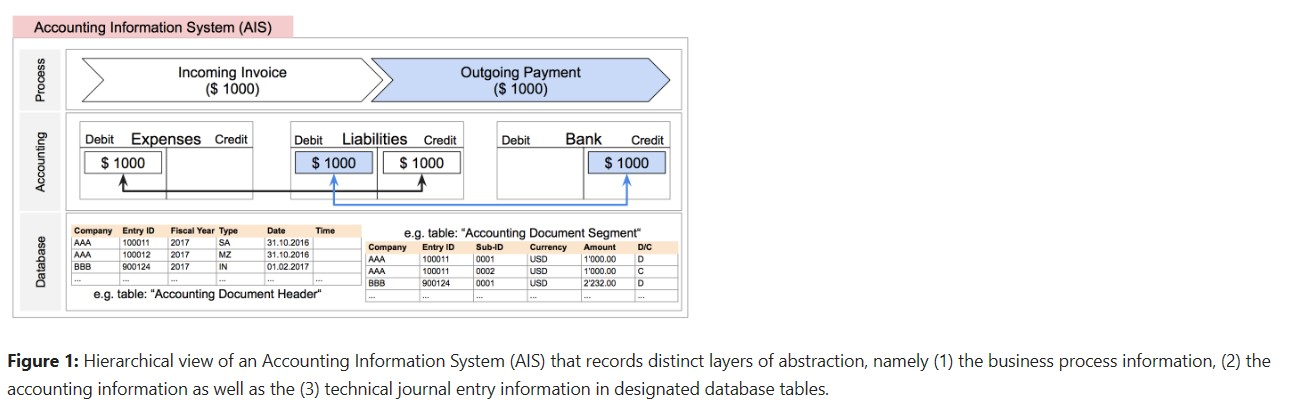

The illustration in Figure 1 depicts a hierarchical view of an Accounting Information System (AIS) recording process and journal entry information in designated database tables f. In the context of fraud examinations, the data collected by such systems may contain valuable traces of a potential fraud scheme and investigating the each general entry may provide a specific que about the anomality at journal entry level.

### 1.1 Python Libraries Import

In [ ]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

### 1.2 Random Seed Initialization
Setting the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [ ]:
# init deterministic seed
USE_CUDA = True
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

### 1.3 Folder Structure Initialization
Creating notebook structure to store the data as well as the trained models:

In [ ]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

## 2. Financial Fraud Detection Dataset
The dataset is based on a derivation of the "Synthetic Financial Dataset For Fraud Detection" by Lopez-Rojas available via the Kaggle by [clicking here](https://www.kaggle.com/code/carambolage/data-science-summer-school-deep-autoencoder-lab/data).

In [ ]:
# load the synthetic ERP dataset
#df = pd.read_csv('./data/fraud_dataset_v2.csv')

# load the synthetic ERP dataset
url = 'https://raw.githubusercontent.com/GitiHubi/deepAI/master/data/fraud_dataset_v2.csv'
df = pd.read_csv(url)

In [ ]:
# inspect the dataset dimensions
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533009 entries, 0 to 533008
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   BELNR   533009 non-null  int64  
 1   WAERS   533009 non-null  object 
 2   BUKRS   533009 non-null  object 
 3   KTOSL   533009 non-null  object 
 4   PRCTR   533009 non-null  object 
 5   BSCHL   533009 non-null  object 
 6   HKONT   533009 non-null  object 
 7   DMBTR   533009 non-null  float64
 8   WRBTR   533009 non-null  float64
 9   label   533009 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 40.7+ MB


## 2.1 Understanding the Data Attributes
The data has been obtained from SAP- ERP finance module called SAP's Finance and Cost controlling (FICO) module.

he dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

- **BELNR**: the accounting document number,
- **BUKRS**: the company code,
- **BSCHL**: the posting key,
- **HKONT**: the posted general ledger account,
- **PRCTR**: the posted profit center,
- **WAERS**: the currency key,
- **KTOSL**: the general ledger account key,
- **DMBTR**: the amount in local currency,
- **WRBTR**: the amount in document currency.

In [ ]:
# inspect top rows of the data
df.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


There is a label field in the data. This field describes the true nature of each individual transaction of either being a regular transaction (denoted by regular) or an anomaly (denoted by global and local). 

In [ ]:
# number of anomalies vs. regular transactions
df.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

The statistic reveals that, similar to real world scenarios, the data is highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of 100 (0.018%) anomalous transactions. While the 100 anomalous entries encompass 70 (0.013%) "global" anomalies and 30 (0.005%) "local" anomalies 

### Classification of Financial Anomalies

When conducting a detailed examination of real-world journal entries, usually recorded in large-scaled AIS or ERP systems, two prevalent characteristics can be observed:

- Specific transactions attributes exhibit a high variety of distinct attribute values e.g. customer information, posted sub-ledgers, amount information, and

- The transactions exhibit strong dependencies between specific attribute values e.g. between customer information and type of payment, posting type and general ledgers.

Derived from this observation two distinguish classes of anomalous journal entries, namely "global" and "local" anomalies is lablled. 
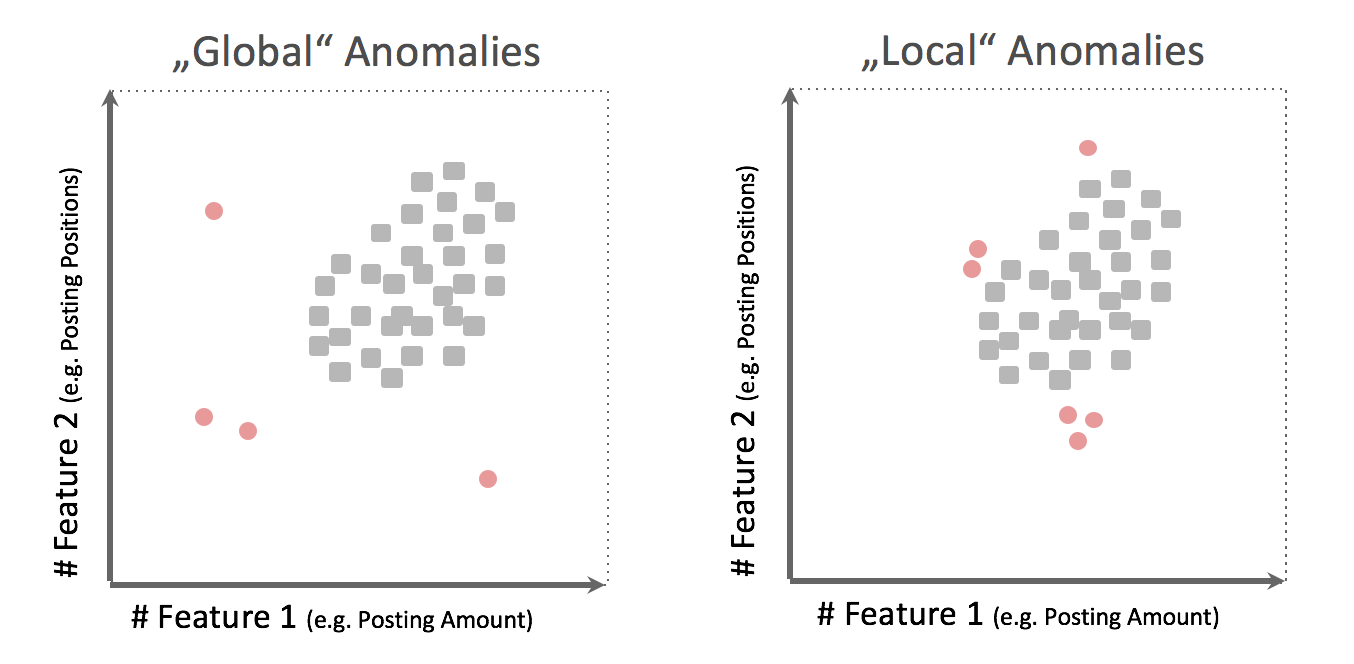

Figure 2: Illustrative example of global and local anomalies portrait in a feature space of the two transaction features "Posting Amount" (Feature 1) and "Posting Positions" (Feature 2).



Local anomaly is significantly more difficult to detect since perpetrators intend to disguise their activities trying to imitate a regular behaviour. As a result, such anomalies usually pose a high fraud risk since they might correspond to e.g. misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow an usual activity pattern.

In [ ]:
# remove the label information from the data
label = df.pop('label')

## 3 Data Pre-Processinga and Visualisation

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO module. 

Visually inspecting the distribution of two of the dataset attributes provided, namely (1) the posting key (technically denoted by BSCHL) as well as (2) the general ledger account (technically denoted by HKONT):

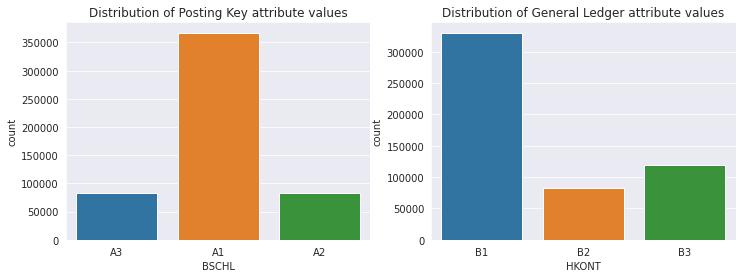

In [ ]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)

# plot the distribution of the posting key attribute
g = sns.countplot(x=df.loc[label=='regular', 'BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of Posting Key attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=df.loc[label=='regular', 'HKONT'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_title('Distribution of General Ledger attribute values');

### 3.1 Coverting the Categorical Values to Numerical values

In [ ]:
# select categorical attributes to be "one-hot" encoded
cols_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
df_categ_transformed = pd.get_dummies(df[cols_names])

In [ ]:
# inspect encoded sample transactions
df_categ_transformed.head(10)

,KTOSL_A19,KTOSL_B06,KTOSL_B12,KTOSL_B83,KTOSL_C1,KTOSL_C2,KTOSL_C3,KTOSL_C39,KTOSL_C4,KTOSL_C5,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 Pre-Processing of Numerical Transaction Attributes

Inspecting the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount DMBTR and the (2) document currency amount WRBTR:

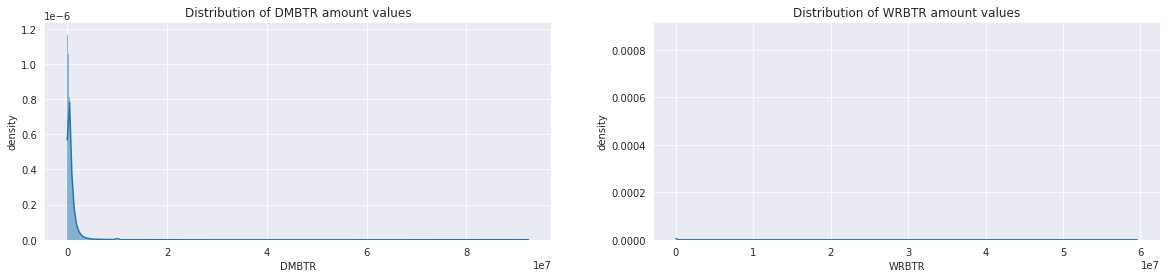

In [ ]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.histplot(df['DMBTR'].tolist(), ax=ax[0], kde=True, stat="density")
g.set_title('Distribution of DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the document amount attribute
g = sns.histplot(df['WRBTR'].tolist(), ax=ax[1],kde=True, stat="density")
g.set_title('Distribution of WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

It can be observed, that for both attributes the distributions of amount values are skewed and encompass a heavy tailed distribution. In order to faster approach a potential global minimum it is good to scale and normalize numerical input values prior to network training. Therefore, I first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [ ]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = df[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
df_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


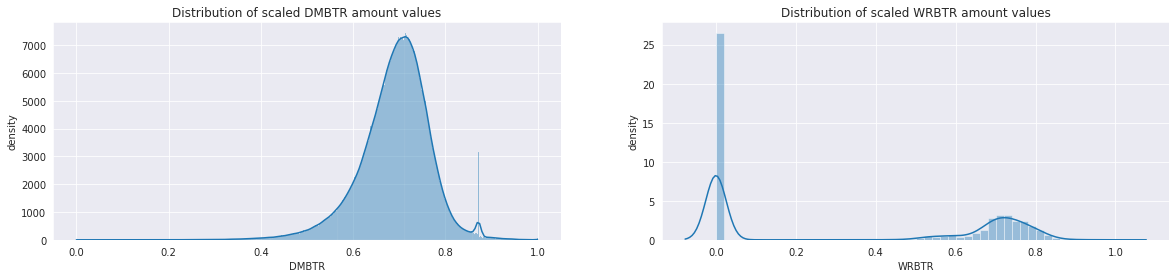

In [ ]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.histplot(df_numeric_attr['DMBTR'].tolist(), ax=ax[0], kde =True)
g.set_title('Distribution of scaled DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the local amount attribute
g = sns.distplot(df_numeric_attr['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of scaled WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

 Now Visualy investigating the scaled distributions of both attributes in terms of the distinct anomaly classes contained in the population of journal entries:

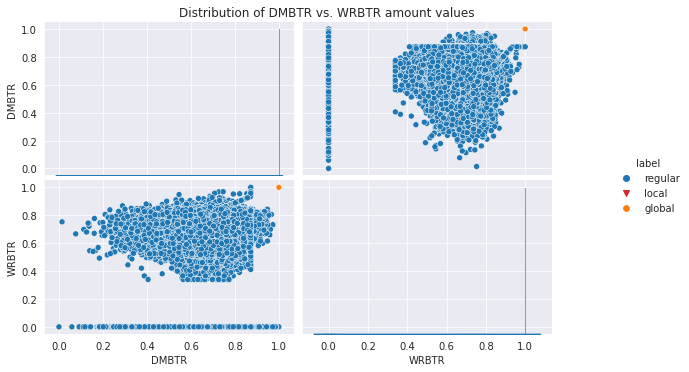

In [ ]:
# append 'label' attribute 
numeric_attr_vis = df_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label', palette={'regular': 'C0', 'local': 'C3', 'global': 'C1'}, markers=['o', 'v', '8'])

# set figure title
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values', y=1.02)

# set figure size
g.fig.set_size_inches(10, 5)

The values of the "global" anomalies (orange) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the values of the "local" anomalies (not visible) are much more commingled within the regular transaction amounts.

### 3.3 Merge Categorical and Numerical Transaction Attributes
I have merged both pre-processed numerical and categorical attributes into a single dataset that I will  be using for training my deep autoencoder neural network.

In [ ]:
# merge categorical and numeric subsets
df_transformed = pd.concat([df_categ_transformed, df_numeric_attr], axis = 1)

Inspecting the dimensionality of the dataset after I applied the distinct pre-processing steps to the attributes:

In [ ]:
# inspect final dimensions of pre-processed transactional data
df_transformed.shape

(533009, 618)

## 4. Adversarial Autoencoder Neural Network
An Adversarial autoencoder(AAE) is quite similar to an autoencoder but the encoder is trained in an adversarial manner to force it to output a required distribution. But It extends the concept of Autoencoder Neural Networks (AE) by imposing an arbitrary prior on the AEs latent space using a Generative Adversarial Network (GAN) training setup. The architecture of AAE is shown below
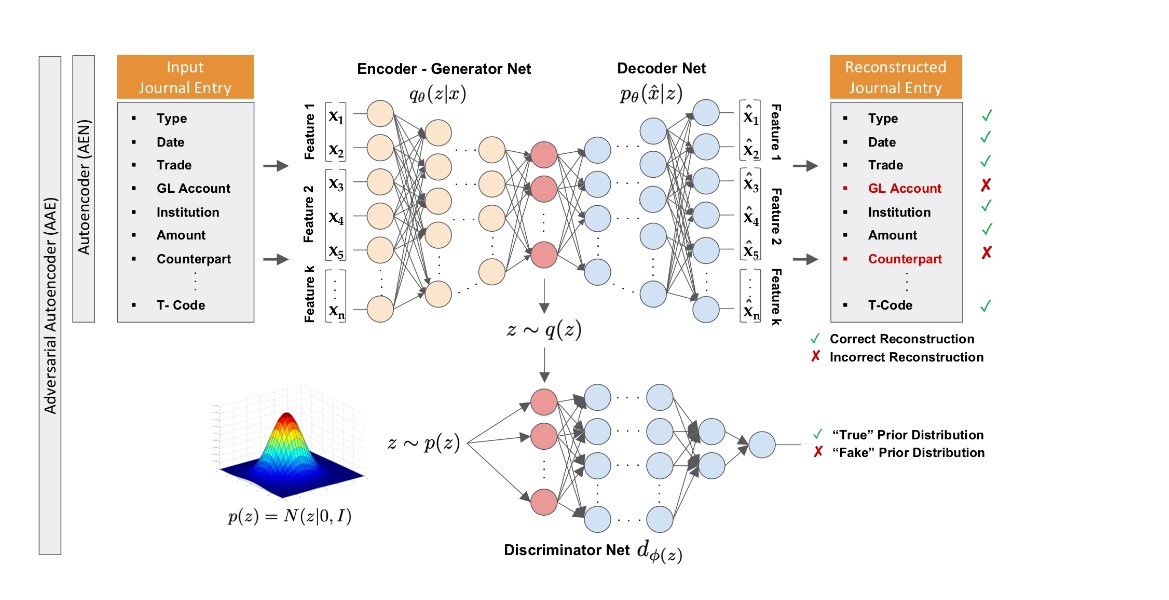

This is achieved by training the AAE jointly in two phases (1) a reconstruction phase as well as (2) an adversarial regularization phase.




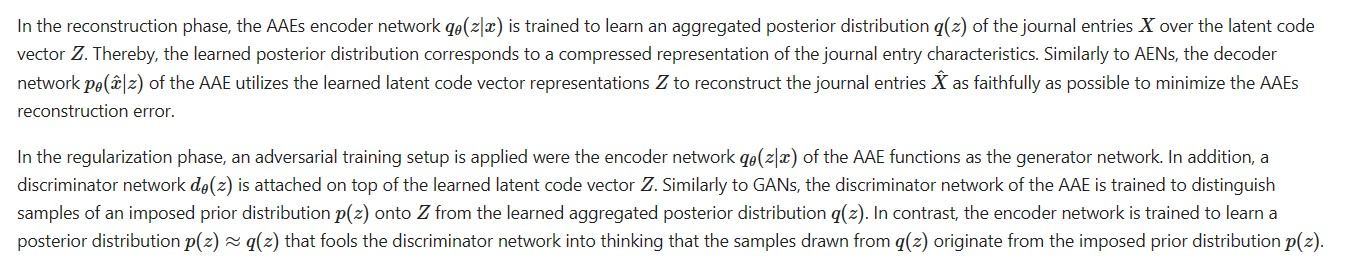

## 4.1 3.1 AAE Implementation - Encoder / Generator Network 

First I am implementing the encoder-generator network 
 using PyTorch. For the encoder-generator, I aim to implement a network consisting of five fully-connected layers. Furthermore, the encoder-generator is specified by the following number of neurons per layer: "618-256-64-16-4-2". Meaning the first layer consists of 618 neurons (specified by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 64, 16, 4 and 2 neurons respectively.

In [ ]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_R5(self.map_L5(x))

        # return result
        return x

Instantiate the encoder-generator model to be trained

In [ ]:
# init training network classes / architectures
encoder_train = Encoder(input_size=df_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder_train.cuda()

Visualize the model structure and review the implemented network architecture

In [ ]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20230106-00:06:24] encoder-generator architecture:

Encoder(
  (map_L1): Linear(in_features=618, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=64, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=64, out_features=16, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=16, out_features=4, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=4, out_features=2, bias=True)
  (map_R5): LeakyReLU(negative_slope=0.4, inplace=True)
)



### 4.2 AAE Implementation - Decoder Network

Implementing the corresponding decoder network. The decoder also consists of five fully-connected layers. Furthermore, the decoder network is intended to symmetrically mirror the encoder networks architecture by a layer wise inversion "2-4-16-64-256" of the encoder network layers.

In [ ]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x


Instantiate the decoder model 

In [ ]:
# init training network classes / architectures
decoder_train = Decoder(output_size=df_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20230106-00:08:12] decoder architecture:

Decoder(
  (map_L1): Linear(in_features=2, out_features=4, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=4, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=64, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=64, out_features=256, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=256, out_features=618, bias=True)
  (map_S5): Sigmoid()
)



### 4.3 AAE Implementation - Discriminator Network 
Implementing the discriminator network 
. The discriminator also consists of five fully-connected layers. Furthermore, the discriminator is specified by the following number of neurons per layer: "256-16-4-2".

In [ ]:
# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.map_L4 = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_S4(self.map_L4(x))

        # return result
        return x

Instantiate the discriminator model

In [ ]:
# init training network classes / architectures
discriminator_train = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20230106-00:11:32] discriminator architecture:

Discriminator(
  (map_L1): Linear(in_features=2, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=4, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=4, out_features=1, bias=True)
  (map_S4): Sigmoid()
)



### 4.4 Adversarial Autoencoder Neural Network Training
Prior to starting the training, we need to define an appropriate loss functions, learning rates and parameter optimization techniques. Remember, we aim to train the adversarial autoencoder jointly in two training phases, namely (1) a reconstruction phase as well as (2) a regularization phase. In the following we will set the training parameters of each training phase.

### 4.4.1 Reconstruction Phase Parameter
In the reconstruction phase, the AAEs encoder network 
 is trained to learn an aggregated posterior distribution  of the journal entries  over the latent code vector . Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder network 
 of the AAE utilizes the learned latent code vector representations  to reconstruct the journal entries 
 as faithfully as possible to minimize the AAEs reconstruction error.

To achieve this optimization objective, we calculate 
- (1) the binary cross-entropy reconstruction error (BCE) of the categorical attribute value encodings 
, e.g., the encoded general ledger account ids, and 
- (2) the mean-squared reconstruction error (MSE) of the numerical attribute value encodings 
, e.g., the encoded posting amount, as given by:
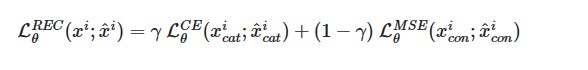

In [ ]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical = nn.BCELoss(reduction='mean')
reconstruction_criterion_numeric = nn.MSELoss(reduction='mean')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical = reconstruction_criterion_categorical.cuda()
    reconstruction_criterion_numeric = reconstruction_criterion_numeric.cuda()

I used the Adam optimization as proposed in and set the learning-rate l=0.001

In [ ]:
# define encoder and decoded learning rate
learning_rate_enc = 1e-3
learning_rate_dec = 1e-3

# define encoder and decoder optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_enc)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_dec)

### 4.4.2 Regularization Phase Parameter
 To train the discriminator to classify the encoder output (z) and some random input(z’, this will have our required distribution). For example, the random input can be normally distributed with a mean of 0 and standard deviation of 5.

So, the discriminator should give us an output 1 if we pass in random inputs with the desired distribution (real values) and should give us an output 0 (fake values) when we pass in the encoder output. Intuitively, both the encoder output and the random inputs to the discriminator should have the same size.

The next step will be to force the encoder to output latent code with the desired distribution. To accomplish this we’ll connect the encoder output as the input to the discriminator. In contrast, the encoder network is trained to learn a posterior distribution  that fools the discriminator network into thinking that the samples drawn from latent space vector originate from the imposed prior distribution (original journal entry).
To achieve this optimization objective, we calculate the binary cross-entropy reconstruction error (BCE), as given by:

In [ ]:
# init the discriminator losses
discriminator_criterion = nn.BCELoss()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    discriminator_criterion = discriminator_criterion.cuda()

I used the Adam optimization as proposed in and set the learning-rate l=0.001

In [ ]:
# define generator and discriminator learning rate
learning_rate_dis_z = 1e-5

# define generator and discriminator optimization strategy
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_dis_z)

### 4.5 Creation of the Imposed Latent Prior Distribution 

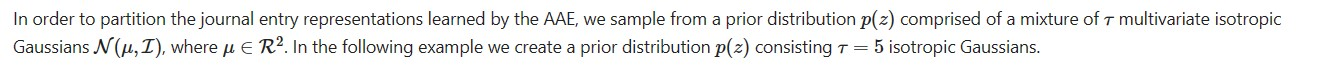

In [ ]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian
    if i == 0:

        # randomly sample from gaussion distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

Visually inspecting the generated prior distribution 

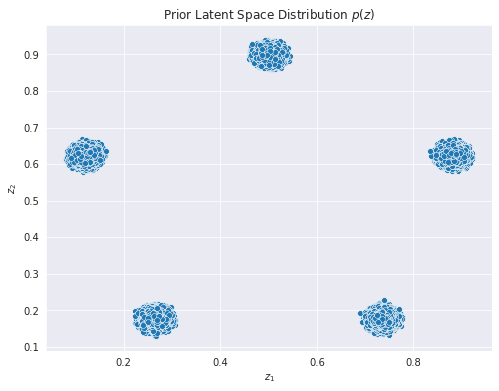

In [ ]:
# init the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.scatter(z_continous_samples_all[:, 0], z_continous_samples_all[:, 1], c='C0', marker="8", edgecolors='w', linewidth=0.5) 
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Prior Latent Space Distribution $p(z)$');

## 5. Training the Adversarial Autoencoder Neural Network (AAE) Model

In this section, I will train my deep adversarial autoencoder neural network (as implemented in section 4. of the project) using the encoded transactional data (created in section 3. of the project) as well as the prior distribution (created in section 4. of the project).

#### 5.1 Preparing the Network Training Data
I will train a corresponding model for 10 epochs and a mini-batch size of 128 journal entries per batch. This implies that the whole dataset will be fed to the AENN 5 times in chunks of 128 journal entries yielding to 4,165 mini-batches (533,009 journal entries / 128 journal entries per mini-batch) per epoch.

In [ ]:
# specify training parameters
num_epochs = 10
mini_batch_size = 128

During the training phase, I will fetch the individual mini-batches of the entire population of journal entries. To achieve this, we will use PyTorch's DataLoader that provides single- or multi-process iterators over a given dataset to load one mini-batch at a time. By enabling shuffle=True the data will be reshuffled at every epoch prior to feeding it to the network.

In [ ]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(df_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

#### 5.2 Running the Network Training

To ensure learning while training our AENN model we will monitor whether the distinct losses decrease with progressing training. Therefore, we obtain and evaluate the reconstruction loss 
, the discrimination loss 
, as well as, the generation loss 
 of the entire dataset after each training epoch.

Initialize the per epoch collected model losses:

In [ ]:
# init collection of training losses
epoch_reconstruction_losses = []
epoch_discriminator_losses = []
epoch_generator_losses = []

Define the verbose step size of the adversarial autoencoder training process:

In [ ]:
mini_batch_verbose_step = 1000

Starting the adversarial autoencoder network training:

In [ ]:
# initialize training adversarial autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0
    
    # init epoch training losses
    batch_reconstruction_losses = 0.0
    batch_discriminator_losses = 0.0
    batch_generator_losses = 0.0

    # determine if GPU training is enabled
    if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

        # set all networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()
        discriminator_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()
    discriminator_train.train()
    
    # start timer
    start_time = datetime.now()

    # iterate over epoch mini batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
          
            # convert mini batch to torch variable
            mini_batch_torch = torch.cuda.FloatTensor(mini_batch_data)

        else:
          
             # convert mini batch to torch variable
             mini_batch_torch = torch.FloatTensor(mini_batch_data)
        
        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== reconstruction phase =====================
        
        # run autoencoder encoding - decoding
        z_sample = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_sample)

        # split input date to numerical and categorical part
        batch_cat = mini_batch_torch[:, :df_categ_transformed.shape[1]]
        batch_num = mini_batch_torch[:, df_categ_transformed.shape[1]:]
        
        # split reconstruction to numerical and categorical part
        rec_batch_cat = mini_batch_reconstruction[:, :df_categ_transformed.shape[1]]
        rec_batch_num = mini_batch_reconstruction[:, df_categ_transformed.shape[1]:]

        # backward pass + gradients update
        rec_error_cat = reconstruction_criterion_categorical(input=rec_batch_cat, target=batch_cat)  # one-hot attr error
        rec_error_num = reconstruction_criterion_numeric(input=rec_batch_num, target=batch_num)  # numeric attr error

        # combine both reconstruction errors
        reconstruction_loss = rec_error_cat + rec_error_num
        
        # run backward pass - determine gradients
        reconstruction_loss.backward()
        
        # collect batch reconstruction loss
        batch_reconstruction_losses += reconstruction_loss.item()
        
        # update network parameter - decoder and encoder
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== regularization phase =====================
        # =================== discriminator training ===================

        # set discriminator in evaluation mode
        discriminator_train.eval()

        # generate target latent space data
        z_target_batch = z_continous_samples_all[random.sample(range(0, z_continous_samples_all.shape[0]), mini_batch_size),:]

        # convert to torch tensor
        z_target_batch = torch.FloatTensor(z_target_batch)

        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
            z_target_batch = z_target_batch.cuda()

        # determine mini batch sample generated by the encoder -> fake gaussian sample
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of both samples
        d_real_gauss = discriminator_train(z_target_batch) # real sampled gaussian 
        d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

        # determine discriminator classification target variables
        d_real_gauss_target = torch.FloatTensor(torch.ones(d_real_gauss.shape)) # real -> 1
        d_fake_gauss_target = torch.FloatTensor(torch.zeros(d_fake_gauss.shape)) # fake -> 0

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_real_gauss_target = d_real_gauss_target.cuda()
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine individual discrimination losses
        discriminator_loss_real = discriminator_criterion(target=d_real_gauss_target, input=d_real_gauss) # real loss
        discriminator_loss_fake = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss
        
        # add real loss and fake loss
        discriminator_loss = discriminator_loss_fake + discriminator_loss_real

        # run backward through the discriminator network
        discriminator_loss.backward()
        
        # collect discriminator loss
        batch_discriminator_losses += discriminator_loss.item()

        # update network the discriminator network parameters
        discriminator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== regularization phase =====================
        # =================== generator training =======================

        # set encoder / generator in training mode
        encoder_train.train()
        
        # reset the encoder / generator networks gradients
        encoder_train.zero_grad()

        # determine fake gaussian sample generated by the encoder / generator
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of fake gaussian sample
        d_fake_gauss = discriminator_train(z_fake_gauss)

        # determine discriminator classification target variables
        d_fake_gauss_target = torch.FloatTensor(torch.ones(d_fake_gauss.shape)) # fake -> 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine discrimination loss of fake gaussian sample
        generator_loss = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss)
        
        # collect generator loss
        batch_generator_losses += generator_loss.item()

        # run backward pass - determine gradients
        generator_loss.backward()

        # update network paramaters - encoder / generatorc
        encoder_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

    # collect epoch training losses - reconstruction loss
    epoch_reconstruction_loss = batch_reconstruction_losses / mini_batch_count
    epoch_reconstruction_losses.extend([epoch_reconstruction_loss])
    
    # collect epoch training losses - discriminator loss
    epoch_discriminator_loss = batch_discriminator_losses / mini_batch_count
    epoch_discriminator_losses.extend([epoch_discriminator_loss])
    
    # collect epoch training losses - generator loss
    epoch_generator_loss = batch_generator_losses / mini_batch_count
    epoch_generator_losses.extend([epoch_generator_loss])
    
    # print epoch reconstruction loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, reconstruction loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_reconstruction_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, discriminator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_discriminator_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, generator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_generator_loss))
    
    # =================== save model snapshots to disk ============================
    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
    # save trained discriminator model file to disk
    decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
    torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

[LOG TRAIN 20230106-00:49:51] epoch: 0001/0010, reconstruction loss: 0.0642
[LOG TRAIN 20230106-00:49:51] epoch: 0001/0010, discriminator loss: 2.2723
[LOG TRAIN 20230106-00:49:51] epoch: 0001/0010, generator loss: 0.6074
[LOG TRAIN 20230106-00:50:40] epoch: 0002/0010, reconstruction loss: 0.0293
[LOG TRAIN 20230106-00:50:40] epoch: 0002/0010, discriminator loss: 1.3868
[LOG TRAIN 20230106-00:50:40] epoch: 0002/0010, generator loss: 0.7008
[LOG TRAIN 20230106-00:51:37] epoch: 0003/0010, reconstruction loss: 0.0243
[LOG TRAIN 20230106-00:51:37] epoch: 0003/0010, discriminator loss: 1.3854
[LOG TRAIN 20230106-00:51:37] epoch: 0003/0010, generator loss: 0.6955
[LOG TRAIN 20230106-00:52:24] epoch: 0004/0010, reconstruction loss: 0.0209
[LOG TRAIN 20230106-00:52:24] epoch: 0004/0010, discriminator loss: 1.3850
[LOG TRAIN 20230106-00:52:24] epoch: 0004/0010, generator loss: 0.6938
[LOG TRAIN 20230106-00:53:19] epoch: 0005/0010, reconstruction loss: 0.0189
[LOG TRAIN 20230106-00:53:19] epoch:

***Evaluating the magnitude of the distinct losses with progressing training:***

Text(0, 0.5, 'reconstruction loss')

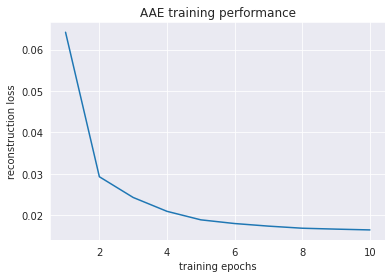

In [ ]:
# plot the reconstruction loss per training epoch
plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# set plot title
plt.title('AAE training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('reconstruction loss')

Text(0, 0.5, 'discrimination loss')

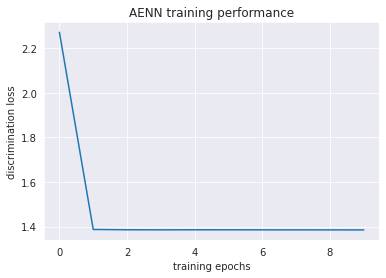

In [ ]:
# plot the discriminator loss per training epoch
plt.plot(range(0, len(epoch_discriminator_losses)), epoch_discriminator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('discrimination loss')

Text(0, 0.5, 'generation loss')

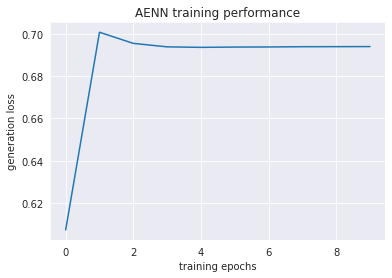

In [ ]:
# plot the generator loss per training epoch
plt.plot(range(0, len(epoch_generator_losses)), epoch_generator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('generation loss')

After 5 epochs, It can be observe that  reconstruction loss already went down significantly and starts to converge nicely. This mean that my netwrok has learned the structure and attributes of journal entry.

## 6. Evaluating the Autoencoder Neural Network (AENN) Model
In order, to detect interpretable accounting anomalies in real-world ERP datasets the researchers propose a novel anomaly score utilizing the introduced AAE architecture. The score builds on the regularisation applied throughout the AAE training process, namely the reconstruction error loss and the adversarial loss, described in the following.

In [ ]:
# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAD/master/models/20190818-03_22_18_ep_401_encoder_model.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAD/master/models/20190818-03_22_18_ep_401_decoder_model.pth'

# Read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# Load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init training network classes / architectures
encoder_eval = Encoder(input_size=df_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])
decoder_eval = Decoder(output_size=df_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    encoder_eval = encoder_eval.cuda()
    decoder_eval = decoder_eval.cuda()
    
# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer))
decoder_eval.load_state_dict(torch.load(decoder_buffer))

<All keys matched successfully>

Specifying a dataloader that provides the ability to evaluate the journal entrie in an "unshuffled" batch-wise manner:

In [ ]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(df_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader_eval = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=0)

# determine if CUDA is available at the compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    
    # push dataloader to CUDA
    dataloader_eval = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=False)

#### 6.1 Visualize the Latent Space Represenation

Performing the feed forward pass through the pretrained encoder model and collect learned representations of all journal entries.

In [ ]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)
    
    # case: initial batch 
    if batch_count == 0:

      # collect reconstruction errors of batch
      z_enc_transactions_all = z_enc_transactions_batch
      
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      z_enc_transactions_all = torch.cat((z_enc_transactions_all, z_enc_transactions_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
z_enc_transactions_all = z_enc_transactions_all.cpu().detach().numpy()

 Visually inspecting the learned latent space representation obtained of each journal entry

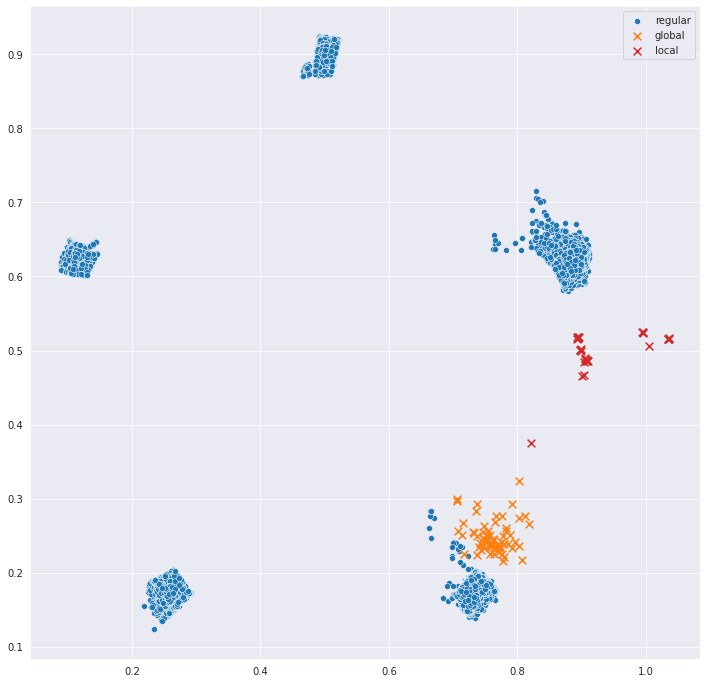

In [ ]:
# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc_transactions_all[label == 'regular']
global_outliers = z_enc_transactions_all[label == 'global']
local_outliers = z_enc_transactions_all[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best');

It can be observed that the AAE learned a rather clean separation of the regular journal entries. The review of the journal entries accounting specific semantics captured by each mode and dataset revealed:

The entries of each partition exhibit a high semantic similarity while each partition corresponds to a general accounting process, such as (1) automated payment run
entries postings, (2) outgoing customer invoices, and (3) material movements.


#### 6.2 Determine Normalized Mode Divergence (MD) of Each Journal Entry

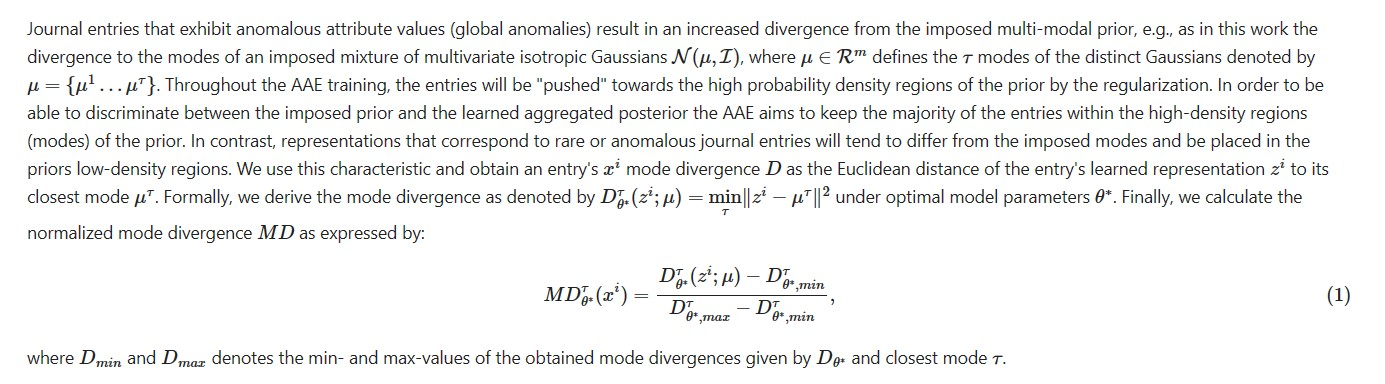

In [ ]:
# define euclidean distance calculation
def compute_euclid_distance(x, y):
    
    # calculate euclidean distance 
    euclidean_distance = np.sqrt(np.sum((x - y) ** 2, axis=1))
    
    # return euclidean distance
    return euclidean_distance

Obtaining the mode assignment and mode divergence of each journal entry

In [ ]:
# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, axis=1, arr=z_enc_transactions_all, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1)    

Normalize the obtained mode divergenes 
 of each mode :

In [ ]:
# normalize the mode divergences of each mode

# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp()) 

Visually inspect the obtained mode divergence obtained of each journal entry 

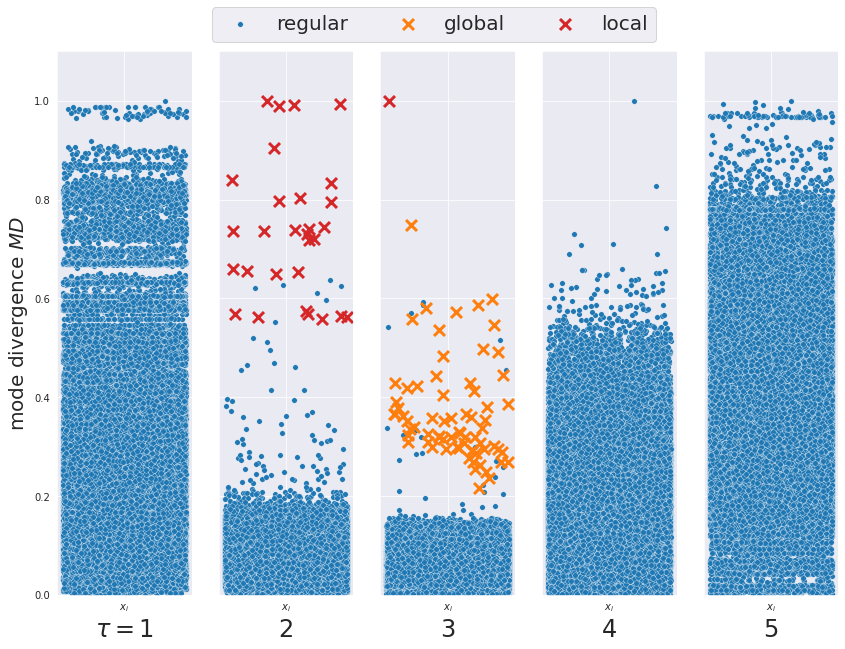

In [ ]:
# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(mode_divergence_all_scaled, name='mode_divergence'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['mode_divergence'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('mode divergence $MD$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)


#### 6.3 Determine Normalized Reconstruction Error (RE) of Each Journal Entry

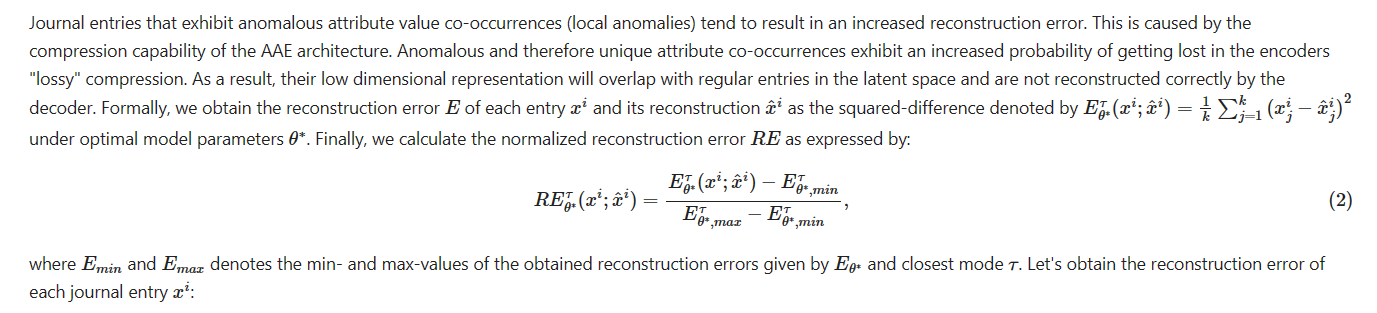

In [ ]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical_eval = nn.BCEWithLogitsLoss(reduction='none')
reconstruction_criterion_numeric_eval = nn.MSELoss(reduction='none')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical_eval = reconstruction_criterion_categorical_eval.cuda()
    reconstruction_criterion_numeric_eval = reconstruction_criterion_numeric_eval.cuda()

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)

    # reconstruct input samples
    reconstruction_batch = decoder_eval(z_enc_transactions_batch)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions_batch[:, :df_categ_transformed.shape[1]]
    input_num_all = enc_transactions_batch[:, df_categ_transformed.shape[1]:]

    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction_batch[:, :df_categ_transformed.shape[1]]
    rec_num_all = reconstruction_batch[:, df_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical_eval(input=rec_cat_all, target=input_cat_all).mean(dim=1)
    rec_error_num_all = reconstruction_criterion_numeric_eval(input=rec_num_all, target=input_num_all).mean(dim=1)

    # combine categorical and numerical errors
    rec_error_all_batch = rec_error_cat_all + rec_error_num_all
    
    # case: initial batch
    if batch_count == 0:
    
      # collect reconstruction errors of batch
      rec_error_all = rec_error_all_batch
    
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      rec_error_all = torch.cat((rec_error_all, rec_error_all_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
rec_error_all = rec_error_all.cpu().detach().numpy()

Normalize the obtained reconstruction errors 
 of each mode :

In [ ]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())

Visually inspecting the reconstruction error obtained for each journal entry 
:

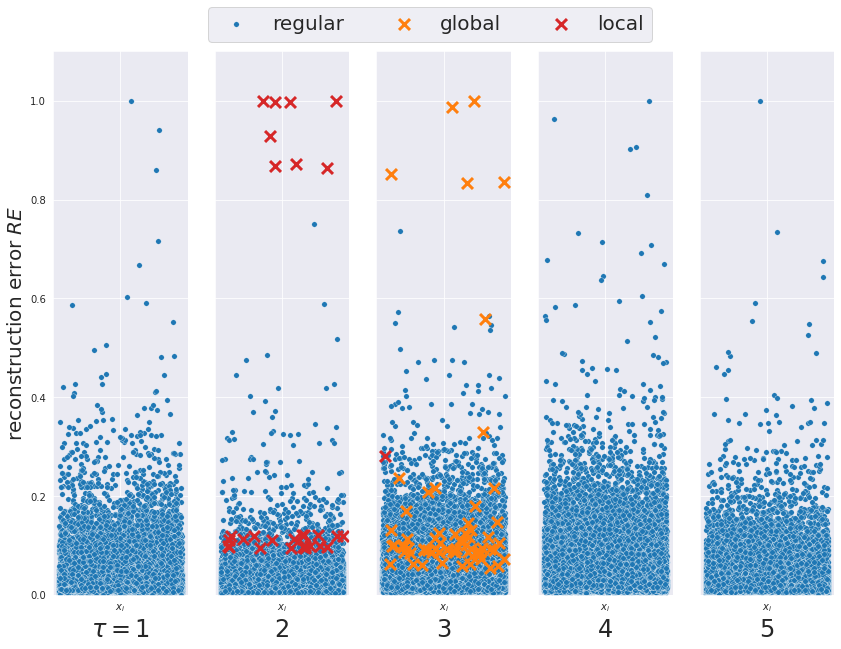

In [ ]:
# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(rec_error_all_scaled, name='rec_error'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['rec_error'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['rec_error'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['rec_error'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('reconstruction error $RE$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

#### 6.3 Determine Anomaly Score of Each Journal Entry
Quantifying both characteristics for a given journal entry, we can reasonably conclude (1) if the entry is anomalous and (2) if it was created by a "regular" business activity. To detect global and local accounting anomalies in real-world audit scenarios the researchers propose to score each journal entry 
 by its normalized reconstruction error  regularized and normalized mode divergence  given by:

 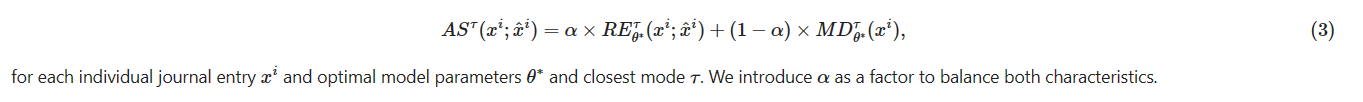

In [ ]:
# set alpha 
alpha = 0.4

# determine journal entry anomaly score
anomaly_score = alpha * rec_error_all_scaled + (1.0 - alpha) * mode_divergence_all_scaled

#### 6.4 Visual Inspection of the Obtained Anomaly Scores

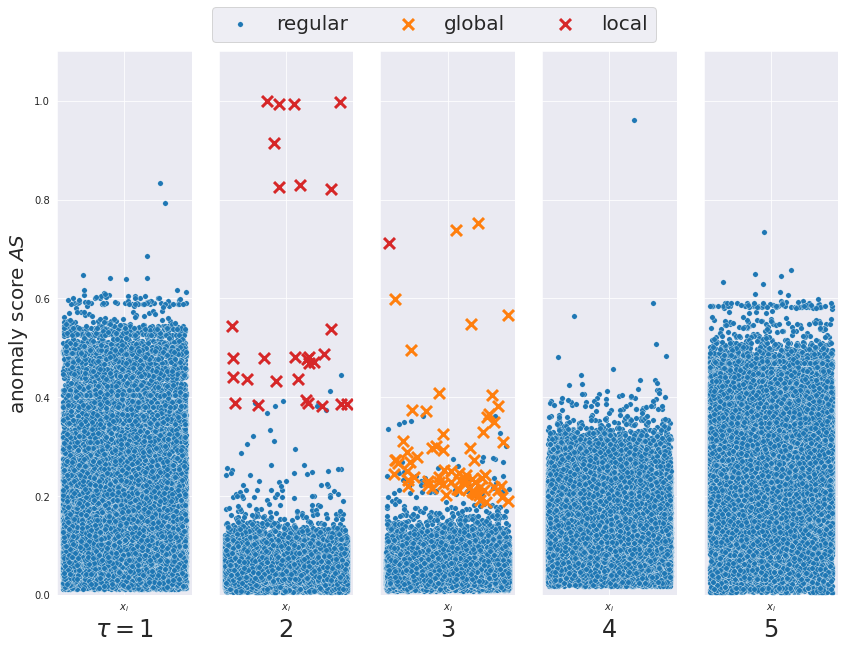

In [ ]:
# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)  

The graph illustrates the change in anomaly scoring when varying the α parameter of the AS. 

Thereby, we can  interpret the detected anomalies of each mode τ in the context
of the modes regular entries:
- **Global anomalies** exhibit a low semantic similarity to the
regular entries of a mode. The detected entries correspond
to rarely observable attribute values and accounting "exceptions"’, e.g., unusual purchase order amounts or high
depreciation, year-end as well as impairment postings.

- **Local anomalies** exhibit high semantic similarity to the
regular entries of a mode. The detected entries correspond to rarely observable attribute value combinations, e.g., system users that switched departments, postings exhibiting
unusual general ledger account combinations.

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (red) from the regular journal entries (blue).

To further investigate the observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting an anomaly score >= 0.25 selected from the cluster mode . We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [ ]:
df['label'] = label
df['tau'] = cluster_ids

# inspect transactions exhibiting a reconstruction error >= 0.2
df[(anomaly_score >= 0.25) & (cluster_ids == 2)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,tau
6287,334152,C2,C22,C1,C19,A1,B1,4.758323e+05,1.000000e+00,regular,2
12939,532980,C1,C20,C1,C18,A1,B1,9.106583e+05,5.444984e+04,local,2
35691,532967,M07,S42,J81,A14,O49,Z01,9.244553e+07,5.958503e+07,global,2
35944,532917,J82,Q22,P32,Z74,Y19,K27,9.244553e+07,5.958504e+07,global,2
41925,532923,T17,R47,D84,F38,I81,D68,9.244552e+07,5.958505e+07,global,2
52048,532958,Q82,S54,J53,T46,Y42,S06,9.244553e+07,5.958503e+07,global,2
54975,529161,C4,C41,C1,C10,A2,B1,5.002054e+05,1.000000e+00,regular,2
68527,318707,C7,C77,C2,C27,A3,B3,7.904000e+01,5.310000e+03,regular,2
71036,532939,B00,O64,T41,Y68,H15,L79,9.244552e+07,5.958503e+07,global,2
75500,274782,C9,C94,C9,C91,A2,B1,1.002600e+02,3.068010e+05,regular,2


Analysing the journal entries exhibiting anomaly score >= 0.4 selected from the cluster mode . We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

In [ ]:
# inspect transactions exhibiting a anomaly_score >= 0.4 from the mode 2
df[(anomaly_score >= 0.4) & (cluster_ids == 1)]

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label,tau
32317,532989,C1,C11,C1,C53,A1,B1,910653.005238,54439.211421,local,1
34058,532991,C1,C11,C1,C91,A1,B1,910668.887465,54440.856583,local,1
34059,533003,C1,C11,C1,C64,A1,B1,910631.632279,54443.283794,local,1
97954,532984,C1,C11,C1,C68,A1,B1,910648.636111,54442.618111,local,1
170320,533001,C1,C11,C1,C30,A1,B1,910645.965114,54452.809780,local,1
183064,533006,C1,C11,C1,C82,A1,B1,910648.873494,54436.705575,local,1
213105,532981,C1,C17,C1,C20,A1,B1,910664.385738,54436.897572,local,1
220927,533002,C1,C11,C1,C60,A1,B1,910648.545092,54446.382830,local,1
234335,532987,C1,C11,C1,C80,A1,B1,910647.596802,54446.113055,local,1
234460,532988,C1,C11,C1,C26,A1,B1,910655.728514,54441.600292,local,1


### Conclusion:


In this project, I showed that Adversarial Autoencoder (AAE) neural networks can be trained to learn meaningful semantic representations of journal entries recorded in ERP systems in the real world. 

It also provides preliminary evidence that such representations provide a
Comprehensive view of input and demystification of the underlying creation processes. I believe the approach presented allows a human auditor or forensic accountant to sample log entries for a detailed audit in a way that is easy to understand and thus reducing "sampling risk". 

In addition, I proposed a new anomaly that combines the learned representation of the input and the reconstruction error. I have demonstrated that scoring can be construed as a highly adaptive and unsupervised anomaly
assessment to detect global and accounting anomalies.